# SI618: Homework 7 - Spaceship Titanic  
Jonas Zhonghan Xie (jonasxie@umich.edu)  
11/20/2024

In [270]:
import pandas as pd
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

## Data Preparation

In [223]:
# Importing the dataset
data = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")

In [224]:
# Brief checking of the training dataset
data.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6350,6719_01,Mars,True,F/1396/P,TRAPPIST-1e,41.0,False,0.0,0.0,0.0,0.0,0.0,Panter Cres,True
5792,6137_01,Earth,False,G/994/S,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Camily Serry,True
1564,1659_01,Earth,False,F/313/S,TRAPPIST-1e,41.0,False,0.0,82.0,3.0,0.0,718.0,Rayle Pugherman,False
902,0972_01,Earth,False,E/54/P,TRAPPIST-1e,21.0,False,0.0,314.0,323.0,1026.0,6.0,Glendy Humphreyes,False
8525,9101_01,Earth,False,F/1865/P,TRAPPIST-1e,21.0,False,NaN,0.0,496.0,430.0,0.0,Gera Frazie,False


In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [226]:
# Present the missing values for each row and the percentages
missing_values = data.isnull().sum().reset_index()
missing_values.columns = ["Feature", "Missing Values"]
missing_values["Percentage"] = (missing_values["Missing Values"] / data.shape[0]) * 100
missing_values

,Feature,Missing Values,Percentage
0,PassengerId,0,0.000000
1,HomePlanet,201,2.312205
2,CryoSleep,217,2.496261
3,Cabin,199,2.289198
4,Destination,182,2.093639
5,Age,179,2.059128
6,VIP,203,2.335212
7,RoomService,181,2.082135
8,FoodCourt,183,2.105142
9,ShoppingMall,208,2.392730


In [227]:
missing_values_test = df_test.isnull().sum().reset_index()
missing_values_test.columns = ["Feature", "Missing Values"]
missing_values_test["Percentage"] = (missing_values_test["Missing Values"] / df_test.shape[0]) * 100
missing_values_test

,Feature,Missing Values,Percentage
0,PassengerId,0,0.000000
1,HomePlanet,87,2.034136
2,CryoSleep,93,2.174421
3,Cabin,100,2.338087
4,Destination,92,2.151040
5,Age,91,2.127660
6,VIP,93,2.174421
7,RoomService,82,1.917232
8,FoodCourt,106,2.478373
9,ShoppingMall,98,2.291326


There is some missingness in both the training and test datasets which needs to take care of. There are about 2% of missingness in both datasets. Dropping them would not be a big deal.

In [228]:
# Dropping na values
data.drop(["Name", "PassengerId"], axis=1, inplace=True)
data.dropna(how="any", inplace=True)

## Exploratory Data Analysis

In [229]:
# Check the dependent variable
data["Transported"].value_counts()
# About half of the observations were transported.

Transported
True     3401
False    3363
Name: count, dtype: int64

In [230]:
# Checking the categorical data, include the missing values
data["HomePlanet"].value_counts()

HomePlanet
Earth     3656
Europa    1711
Mars      1397
Name: count, dtype: int64

In [231]:
data["Destination"].value_counts()

Destination
TRAPPIST-1e      4682
55 Cancri e      1442
PSO J318.5-22     640
Name: count, dtype: int64

In [232]:
data["CryoSleep"].value_counts()

CryoSleep
False    4384
True     2380
Name: count, dtype: int64

In [233]:
data["VIP"].value_counts()

VIP
False    6600
True      164
Name: count, dtype: int64

In [234]:
# Split the Cabin into three separate columns to extract more information
data["Cabin"] = data["Cabin"].fillna("Unknown")
data[["Cabin_1", "Cabin_2", "Cabin_3"]] = data["Cabin"].str.split("/", expand=True)
data[data["Cabin_1"] == "Unknown"] = np.nan

In [236]:
data["Cabin_1"].value_counts()

Cabin_1
F    2208
G    2019
E     700
B     641
C     599
D     381
A     213
T       3
Name: count, dtype: int64

In [237]:
data["Cabin_3"].value_counts()

Cabin_3
S    3425
P    3339
Name: count, dtype: int64

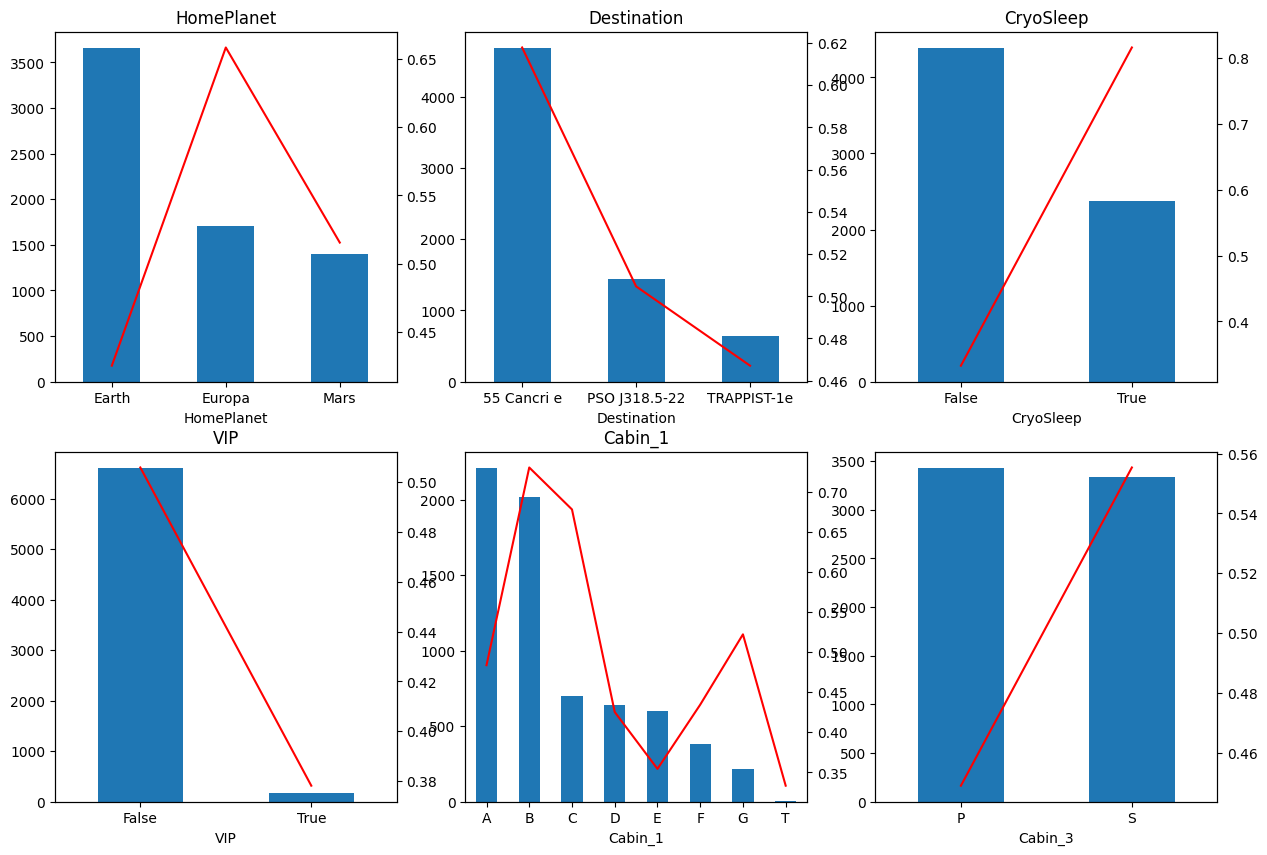

In [238]:
# Present bar charts for all categorical variables
# Calculate the probability of being transported for each category and overlay the bar chart

# Calculate the probability of being transported for each category
transported_prob = data.groupby("HomePlanet")["Transported"].mean()
destination_prob = data.groupby("Destination")["Transported"].mean()
cryosleep_prob = data.groupby("CryoSleep")["Transported"].mean()
vip_prob = data.groupby("VIP")["Transported"].mean()
cabin_prob = data.groupby("Cabin_1")["Transported"].mean()
cabin_class_prob = data.groupby("Cabin_3")["Transported"].mean()

# Plot bar charts with overlayed probability
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
data["HomePlanet"].value_counts().plot(kind="bar")
transported_prob.plot(kind="line", color="red", secondary_y=True)
plt.title("HomePlanet")
plt.subplot(2, 3, 2)
data["Destination"].value_counts().plot(kind="bar")
destination_prob.plot(kind="line", color="red", secondary_y=True)
plt.title("Destination")
plt.subplot(2, 3, 3)
data["CryoSleep"].value_counts().plot(kind="bar")
cryosleep_prob.plot(kind="line", color="red", secondary_y=True)
plt.title("CryoSleep")
plt.subplot(2, 3, 4)
data["VIP"].value_counts().plot(kind="bar")
vip_prob.plot(kind="line", color="red", secondary_y=True)
plt.title("VIP")
plt.subplot(2, 3, 5)
data["Cabin_1"].value_counts().plot(kind="bar")
cabin_prob.plot(kind="line", color="red", secondary_y=True)
plt.title("Cabin_1")
plt.subplot(2, 3, 6)
data["Cabin_3"].value_counts().plot(kind="bar")
cabin_class_prob.plot(kind="line", color="red", secondary_y=True)

plt.show()

Based on the frequencies and the probability of being transported in each category, It seems that `HomePlanet`, `CryoSleep`, `Cabin_1` and `Cabin_3` are good predictors for the probability of being transported.

In [239]:
data.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'Cabin_1', 'Cabin_2', 'Cabin_3'],
      dtype='object')

In [240]:
# Check the numerical data
num_col = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
cat_col = ["HomePlanet", "CryoSleep", "Cabin_1", "Cabin_3", "Destination", "VIP"]

<Figure size 1000x1000 with 0 Axes>

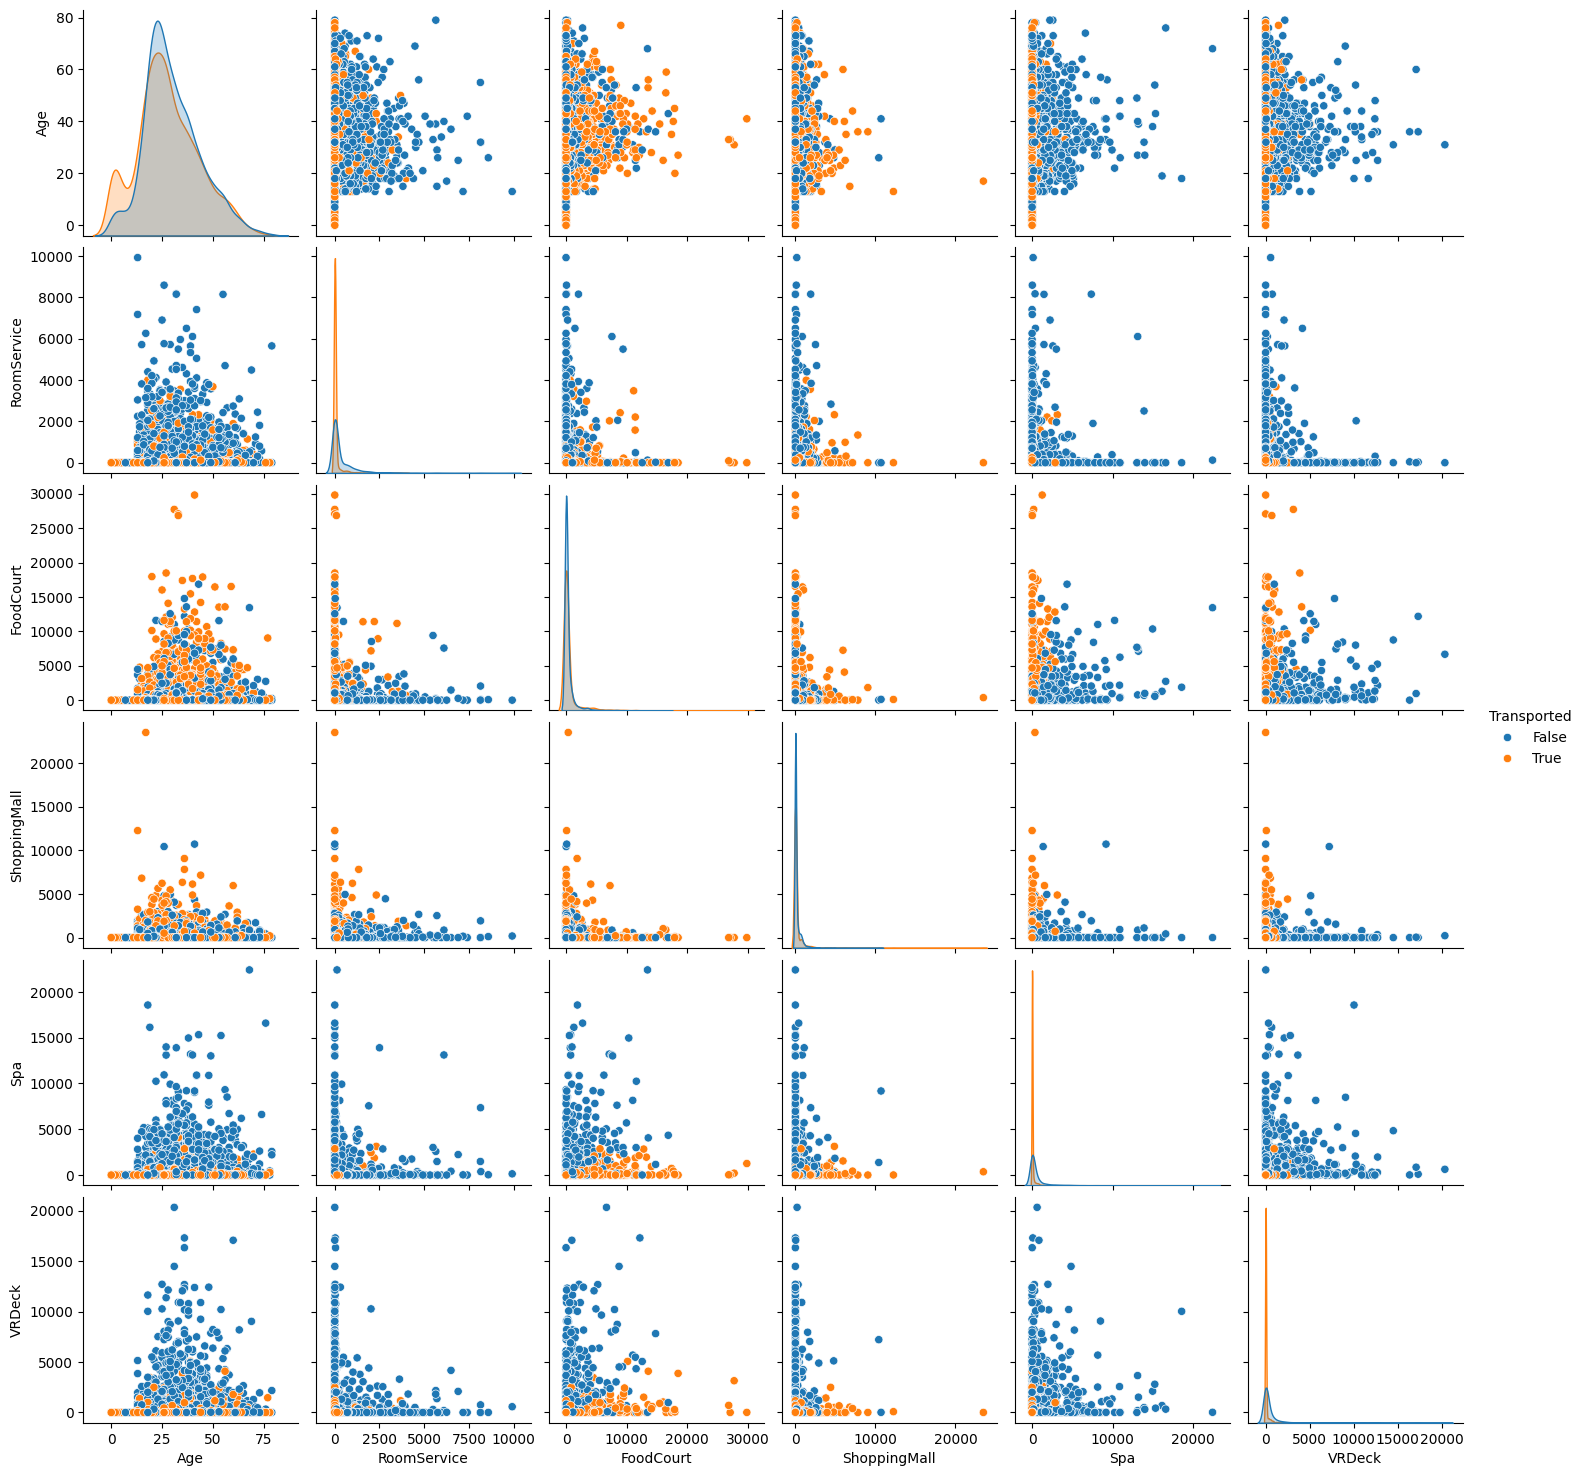

In [241]:
# Draw a pairplot to check the relationship between the numerical variables
plt.figure(figsize=(10, 10))
sns.pairplot(data[num_col + ["Transported"]], hue="Transported")
plt.show()

The histograms of numerical variables except for `Age` are heavily right-skewed. I will take the log transformation for the rest of the numerical variables to make them more normally distributed.

In [242]:
# Log transformation of the numerical variables
data["ln_RoomService"] = np.log(data["RoomService"] + 1)
data["ln_FoodCourt"] = np.log(data["FoodCourt"] + 1)
data["ln_ShoppingMall"] = np.log(data["ShoppingMall"] + 1)
data["ln_Spa"] = np.log(data["Spa"] + 1)
data["ln_VRDeck"] = np.log(data["VRDeck"] + 1)

<Figure size 1000x1000 with 0 Axes>

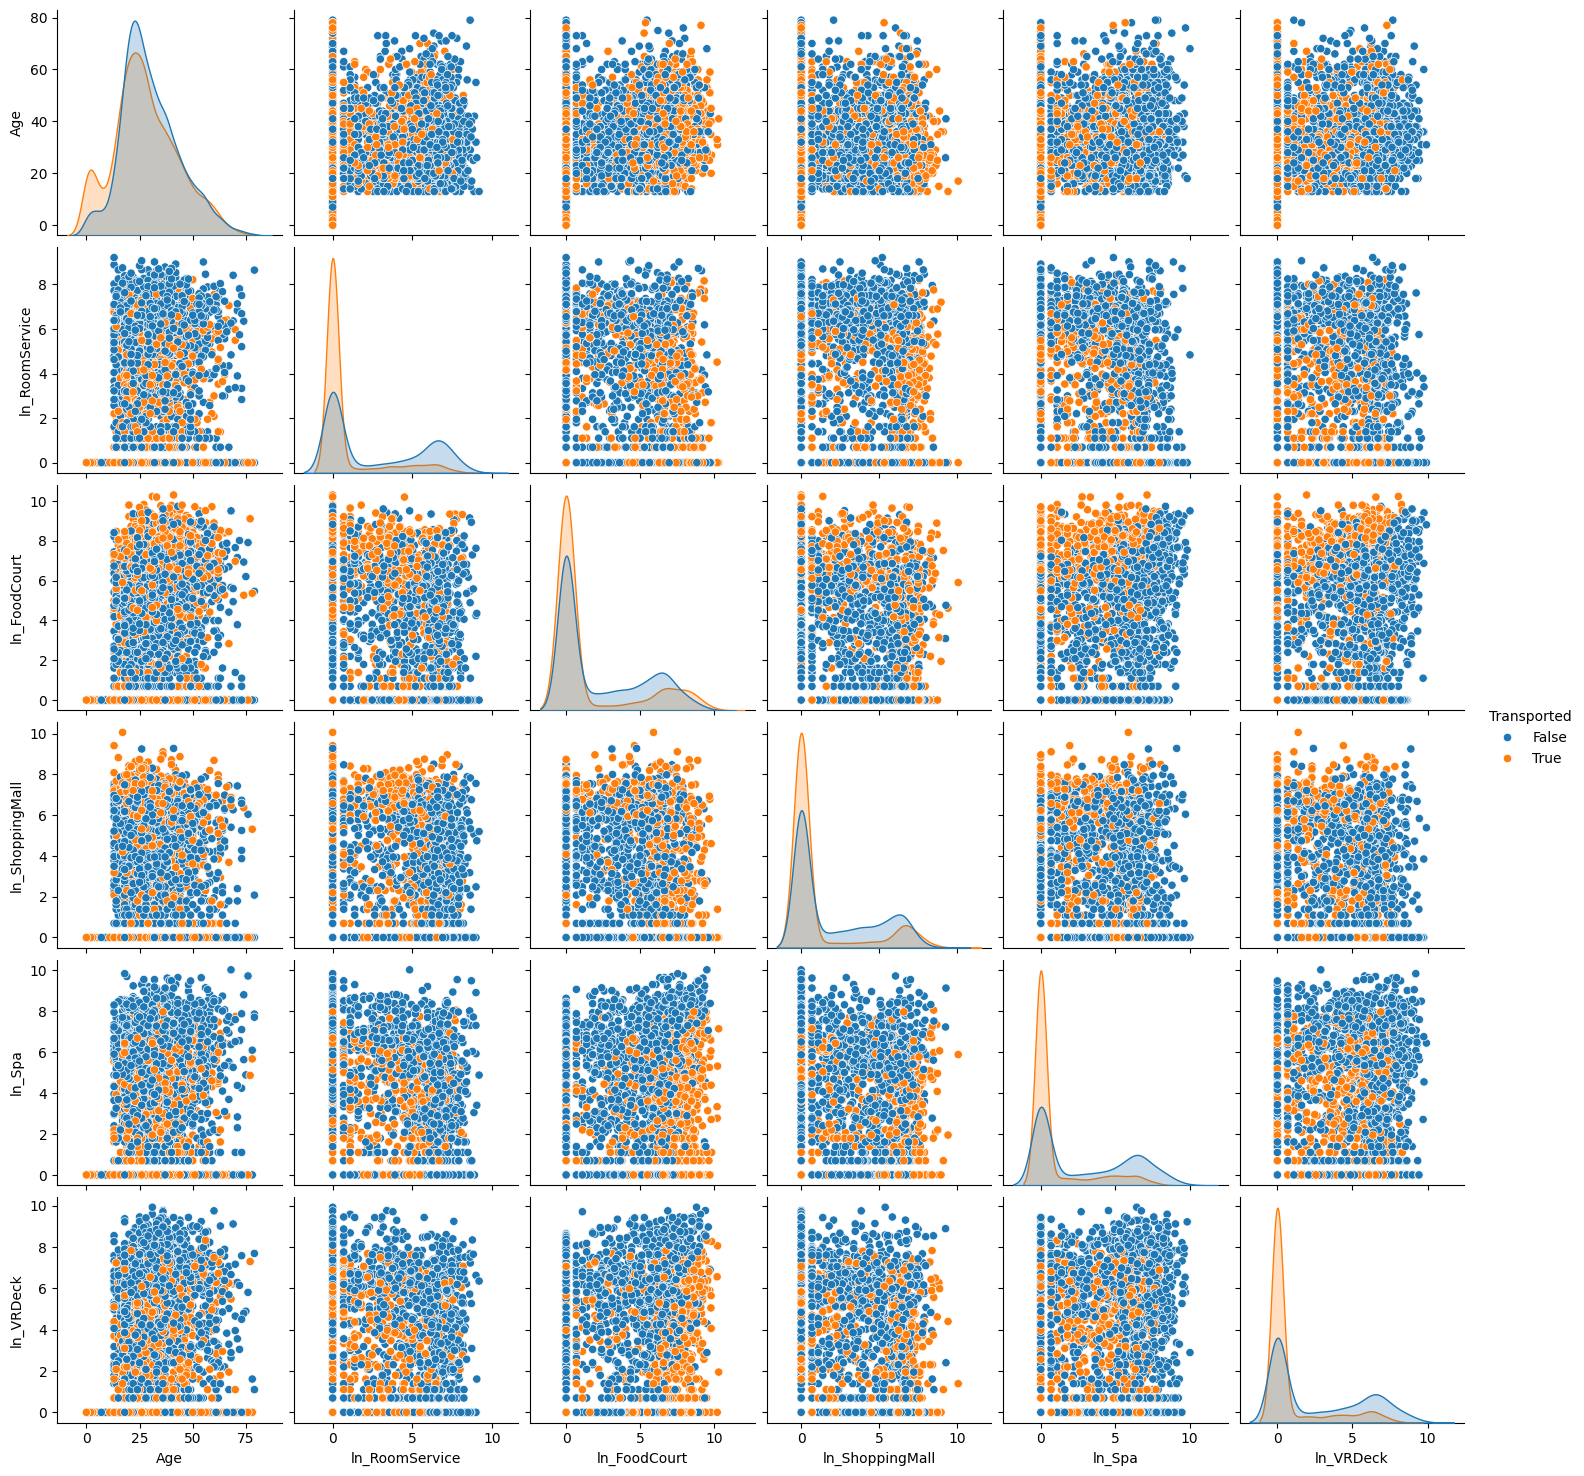

In [243]:
num_lncol = ["Age", "ln_RoomService", "ln_FoodCourt", "ln_ShoppingMall", "ln_Spa", "ln_VRDeck"]
plt.figure(figsize=(10, 10))
sns.pairplot(data[num_lncol + ["Transported"]], hue="Transported")
plt.show()

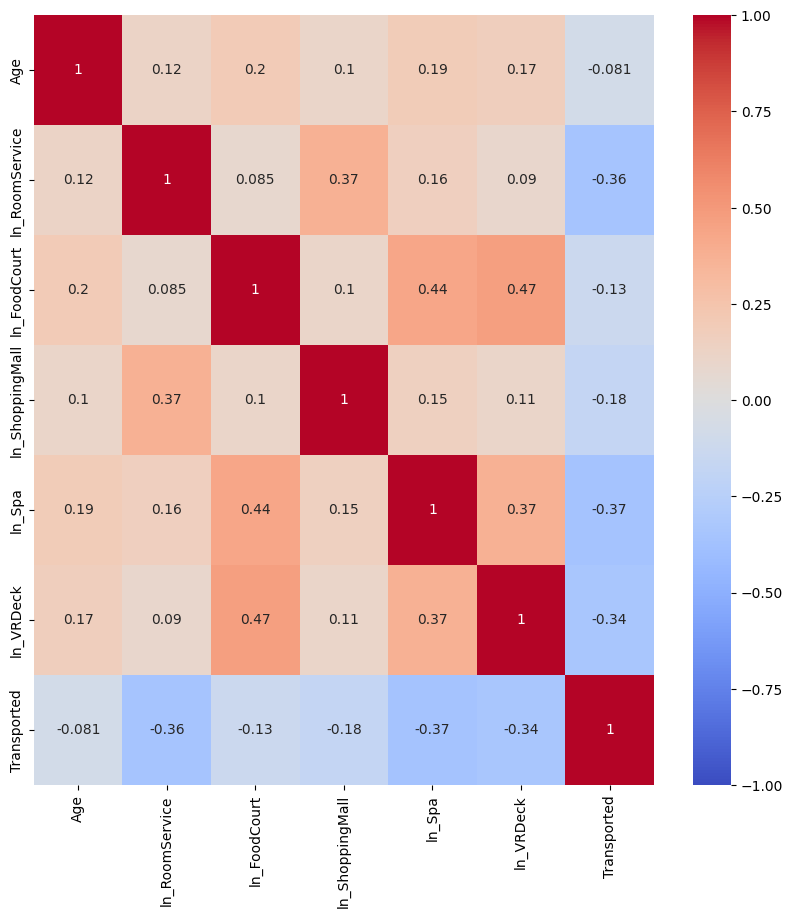

In [244]:
# Draw a correlation matrix to check the relationship between the numerical variables and being transported
plt.figure(figsize=(10, 10))
sns.heatmap(data[num_lncol + ["Transported"]].corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

Both the pairwise scatter plots and the correlation heatmap show that there are moderate correlations between `FoodCourt`, `Spa` and `VRDeck`. In terms of predicting the probability of being transported, `RoomService`, `Spa` and `VRDeck` are somewhat useful.

## Model Building
- Logistic Regression Model
- Random Forest Model
- XGBoost Model/LightGBM Model

### Logistic Regression Model

In [245]:
#
X = data[num_lncol + cat_col]
y = data["Transported"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [246]:
# Build up a Logistic Regression to first check the importance of the features
preprocessor = ColumnTransformer(
    transformers=[("num", StandardScaler(handle_unknown='ignore'), num_lncol), ("cat", OneHotEncoder(), cat_col)]
)

pipeline = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [("num", StandardScaler(), num_lncol), ("cat", OneHotEncoder(), cat_col)]
            ),
        ),
        ("classifier", LogisticRegression(solver="liblinear")),
    ]
)

In [247]:
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy Score of Logistic Regression Model is: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Accuracy Score of Logistic Regression Model is: 0.7842
Classification Report
              precision    recall  f1-score   support

       False       0.81      0.76      0.78       699
        True       0.76      0.81      0.78       654

    accuracy                           0.78      1353
   macro avg       0.78      0.78      0.78      1353
weighted avg       0.79      0.78      0.78      1353

Confusion Matrix
[[533 166]
 [126 528]]


In [248]:
# Finetune the Logistic Regression Model with Cross Validation
pipeline = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [("num", StandardScaler(), num_lncol), ("cat", OneHotEncoder(), cat_col)]
            ),
        ),
        (
            "classifier",
            LogisticRegressionCV(
                solver="liblinear", cv=5, penalty='l1', Cs=20, max_iter=1000, random_state=42
            ),
        ),
    ]
)

accuracy = 0
for cs in range(1, 70, 5):
    pipeline.named_steps["classifier"].Cs = cs
    log_cv_model = pipeline.fit(X_train, y_train)
    y_pred = log_cv_model.predict(X_test)
    print(f"Accuracy Score of Logistic Regression Model is: {accuracy_score(y_test, y_pred):.4f} with Cs={cs}")
    if accuracy_score(y_test, y_pred) > accuracy:
        accuracy = accuracy_score(y_test, y_pred)
        best_cs = cs

pipeline.named_steps["classifier"].Cs = best_cs
log_cv_model = pipeline.fit(X_train, y_train)
y_pred = log_cv_model.predict(X_test)
print("\nThe Best Cs is: ", best_cs)
print(f"Accuracy Score of Logistic Regression Model is: {accuracy_score(y_test, y_pred):.4f} with Cs={best_cs}")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


Accuracy Score of Logistic Regression Model is: 0.5166 with Cs=1
Accuracy Score of Logistic Regression Model is: 0.7827 with Cs=6
Accuracy Score of Logistic Regression Model is: 0.7842 with Cs=11
Accuracy Score of Logistic Regression Model is: 0.7849 with Cs=16
Accuracy Score of Logistic Regression Model is: 0.7857 with Cs=21
Accuracy Score of Logistic Regression Model is: 0.7857 with Cs=26
Accuracy Score of Logistic Regression Model is: 0.7849 with Cs=31
Accuracy Score of Logistic Regression Model is: 0.7871 with Cs=36
Accuracy Score of Logistic Regression Model is: 0.7871 with Cs=41
Accuracy Score of Logistic Regression Model is: 0.7849 with Cs=46
Accuracy Score of Logistic Regression Model is: 0.7849 with Cs=51
Accuracy Score of Logistic Regression Model is: 0.7857 with Cs=56
Accuracy Score of Logistic Regression Model is: 0.7849 with Cs=61
Accuracy Score of Logistic Regression Model is: 0.7849 with Cs=66

The Best Cs is:  36
Accuracy Score of Logistic Regression Model is: 0.7871 wi

### Random Forest Model

In [249]:
# Build up a Random Forest Model pipeline
from random import Random


pipeline = Pipeline(
    [
        (
            "preprocessor", ColumnTransformer
                ([("num", StandardScaler(), num_lncol),
                ("cat", OneHotEncoder(handle_unknown='ignore'), cat_col)]),
        ),
        ("classifier", RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')),
    ]
)


In [250]:
# Fit the Random Forest Model and check the accuracy
rf_model = pipeline.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(f"Accuracy Score of Random Forest Model is: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


Accuracy Score of Random Forest Model is: 0.8056
Classification Report
              precision    recall  f1-score   support

       False       0.80      0.84      0.82       699
        True       0.82      0.77      0.79       654

    accuracy                           0.81      1353
   macro avg       0.81      0.80      0.80      1353
weighted avg       0.81      0.81      0.81      1353

Confusion Matrix
[[585 114]
 [149 505]]


In [252]:
# Finetune the Random Forest Model with GridSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(pipeline, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1, 
                           error_score="raise")

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
'Best Parameters'
{'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy Score of Random Forest Model is: 0.8106
Classification Report
              precision    recall  f1-score   support

       False       0.80      0.82      0.81       699
        True       0.81      0.78      0.79       654

    accuracy                           0.80      1353
   macro avg       0.80      0.80      0.80      1353
weighted avg       0.80      0.80      0.80      1353

Confusion Matrix
[[575 124]
 [141 513]]


In [253]:
print("Best Parameters")
pprint(grid_search.best_params_)
print(f"Accuracy Score of Random Forest Model is: {grid_search.best_score_:.4f}")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Best Parameters
{'classifier__max_depth': 10,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 300}
Accuracy Score of Random Forest Model is: 0.8106
Classification Report
              precision    recall  f1-score   support

       False       0.80      0.82      0.81       699
        True       0.81      0.78      0.79       654

    accuracy                           0.80      1353
   macro avg       0.80      0.80      0.80      1353
weighted avg       0.80      0.80      0.80      1353

Confusion Matrix
[[575 124]
 [141 513]]


### XGBoost Model

In [259]:
pipeline = Pipeline(
    [
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), num_lncol),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_col)
        ])),
        ('classifier', XGBClassifier(n_estimators=100, 
                                     random_state=42,
                                     use_label_encoder=False))
    ]
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"Accuracy Score of XGBoost Model is: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


Accuracy Score of XGBoost Model is: 0.8012
Classification Report
              precision    recall  f1-score   support

       False       0.81      0.81      0.81       699
        True       0.79      0.79      0.79       654

    accuracy                           0.80      1353
   macro avg       0.80      0.80      0.80      1353
weighted avg       0.80      0.80      0.80      1353

Confusion Matrix
[[565 134]
 [135 519]]


c:\Users\Administrator\Documents\SI Courses\SI618\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [260]:
param_grid = {
    "classifier__gamma": [0, 0.1, 0.5, 1],
    "classifier__max_depth": [3, 5, 7],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__min_child_weight": [1, 3, 5],
    "classifier__subsample": [0.5, 0.7, 1],
}

grid_search = GridSearchCV(pipeline, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1, 
                           error_score="raise")
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\Administrator\Documents\SI Courses\SI618\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'ln_RoomService',
                                                                          'ln_FoodCourt',
                                                                          'ln_ShoppingMall',
                                                                          'ln_Spa',
                                                                          'ln_VRDeck']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['HomePlanet',
                                                                          'CryoSleep',
                                                                          'Cabin_1',
                                                                          'Cabin_3',
                                                                          'Destination',
                                                                          'VIP'])])),
                                       ('classifier',
                                        XGB...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__gamma': [0, 0.1, 0.5, 1],
                         'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__min_child_weight': [1, 3, 5],
                         'classifier__subsample': [0.5, 0.7, 1]},
             scoring='accuracy', verbose=1)

In [261]:
print("Best Parameters")
pprint(grid_search.best_params_)
print(f"Accuracy Score of XGBoost Model is: {grid_search.best_score_:.4f}")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Best Parameters
{'classifier__gamma': 0.1,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 5,
 'classifier__min_child_weight': 5,
 'classifier__subsample': 0.7}
Accuracy Score of XGBoost Model is: 0.8139
Classification Report
              precision    recall  f1-score   support

       False       0.81      0.81      0.81       699
        True       0.79      0.79      0.79       654

    accuracy                           0.80      1353
   macro avg       0.80      0.80      0.80      1353
weighted avg       0.80      0.80      0.80      1353

Confusion Matrix
[[565 134]
 [135 519]]


### LightGBM

In [263]:
# Build up the pipeline
pipeline = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [("num", StandardScaler(), num_lncol),
                 ("cat", OneHotEncoder(handle_unknown='ignore'), cat_col)]
            ),
        ),
        (
            "classifier",
            LGBMClassifier(n_estimators=100, random_state=42, objective='binary')
        ),
    ]
)

In [264]:
param_grid = {
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__num_boost_round": [100, 200, 300],
    "classifier__max_depth": [-1, 3, 5, 10],
    "classifier__num_leaves": [31, 50, 100],
    "classifier__subsample": [0.5, 0.7, 1]
}

grid_search = GridSearchCV(pipeline, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=1, 
                           error_score="raise")

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Info] Number of positive: 2747, number of negative: 2664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 5411, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507670 -> initscore=0.030681
[LightGBM] [Info] Start training from score 0.030681


c:\Users\Administrator\Documents\SI Courses\SI618\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [265]:
print("Best Parameters")
pprint(grid_search.best_params_)
print(f"Accuracy Score of LightGBM Model is: {grid_search.best_score_:.4f}")
print("Classification Report")
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

Best Parameters
{'classifier__learning_rate': 0.05,
 'classifier__max_depth': -1,
 'classifier__num_boost_round': 100,
 'classifier__num_leaves': 50,
 'classifier__subsample': 0.5}
Accuracy Score of LightGBM Model is: 0.8128
Classification Report
              precision    recall  f1-score   support

       False       0.81      0.81      0.81       699
        True       0.80      0.80      0.80       654

    accuracy                           0.81      1353
   macro avg       0.81      0.81      0.81      1353
weighted avg       0.81      0.81      0.81      1353

Confusion Matrix
[[568 131]
 [130 524]]


### Model Comparison

The best model for Logistic Regression, Random Forest, XGBoost and LightGBM are as follows:
- Logistic Regression: Accuracy 0.7871
- Random Forest: Accuracy 0.8106
- XGBoost: Accuracy 0.8139
- LightGBM: Accuracy 0.8128

The best model is XGBoost with an accuracy of 0.8139. The parameters of the best model are as follows:
- 'classifier__gamma': 0.1,
- 'classifier__learning_rate': 0.1,
- 'classifier__max_depth': 5,
- 'classifier__min_child_weight': 5,
- 'classifier__subsample': 0.7

## Prediction

In [282]:
df_test = pd.read_csv("./test.csv")

# Predict the test dataset
df_test["ln_RoomService"] = np.log(df_test["RoomService"] + 1)
df_test["ln_FoodCourt"] = np.log(df_test["FoodCourt"] + 1)
df_test["ln_ShoppingMall"] = np.log(df_test["ShoppingMall"] + 1)
df_test["ln_Spa"] = np.log(df_test["Spa"] + 1)
df_test["ln_VRDeck"] = np.log(df_test["VRDeck"] + 1)
# Split the Cabin into three separate columns to extract more information
df_test["Cabin"] = df_test["Cabin"].fillna("Unknown")
df_test[["Cabin_1", "Cabin_2", "Cabin_3"]] = df_test["Cabin"].str.split("/", expand=True)
df_test[df_test["Cabin_1"] == "Unknown"] = np.nan


In [277]:

pipeline = Pipeline([
    (
        'preprocessor',
        ColumnTransformer([
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), num_lncol),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), cat_col)
     ])),
     (
        'classifier',
        XGBClassifier(n_estimators=100, 
                        random_state=42, 
                        use_label_encoder=False,
                        learning_rate=0.1,
                        max_depth=5,
                        min_child_weight=5,
                        subsample=0.7,
                        gamma=0.1))
])

# Predict the test dataset with XGboost

X_test = df_test[num_lncol + cat_col]
pipeline.fit(X,y)
y_pred = pipeline.predict(X_test)
y_pred


c:\Users\Administrator\Documents\SI Courses\SI618\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


array([1, 0, 1, ..., 1, 1, 1])

In [287]:
df_submission = pd.read_csv("sample_submission.csv")
df_submission["prediction"] = y_pred
df_submission["Transported"] = df_submission["prediction"].map({0: "False", 1: "True"})
df_submission.drop("prediction", axis=1, inplace=True)
df_submission.to_csv("submission.csv", index=False)
